In [123]:
%reset -f

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import LinearNDInterpolator as lNDI
from scipy.interpolate import interp1d
import time
import h5py
import five_sigma_depth_func_of_time
import pickle
import time
import sata_funcs as st
import os

In [125]:
labs=['t','flux','flux_err']
# uabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
# gabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
rabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
iabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
zabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
yabnd_data = np.dtype([('t',float), ('flux',float), ('flux_err',float),])
tables=[rabnd_data,iabnd_data,zabnd_data,yabnd_data]
def dump_to_h5(data,labs):
    [sysn,lc_data]=data
    #tu,Fu,Fuerr,tg,Fg,Fgerr,tr,Fr,Frerr,ti,Fi,Fierr,tz,Fz,Fzerr,ty,Fy,Fyerr=lc_data

    grp = h5f.create_group('SystemNo_' + str(sysn))
    for iband,band in enumerate(filters): 
        table=tables[iband]
        t,f,ferr=lc_data[3*iband], lc_data[3*iband+1], lc_data[3*iband+2]
        tepm_arr = np.empty(dtype=table,shape=(t.shape[0],))
        tepm_arr[labs[0]] = t
        tepm_arr[labs[1]] = f
        tepm_arr[labs[2]] = ferr
        band_lab=band+'_data'
        grp.create_dataset(band_lab,data=tepm_arr)
        
        
        
        
def get_mu(kappa,gamma):
    return 1.0/((1.-kappa)**2-gamma**2)

m_ref=0;F_ref=1.0e12
def get_flux(m):
    return F_ref*10**(0.4*(m_ref-m))

def get_mag(F):
    return m_ref-2.5*np.log10(F/F_ref)

def get_flu_err(m,sig_m):
    delF_delm=-0.4*np.log(10.)*F_ref*10**(0.4*(m_ref-m))
    sigF=np.abs(delF_delm)*sig_m
    
    return sigF

def get_flu_err2(m,sig_m):
    del_F=get_mag(m+sig_m)-get_mag(m-sig_m)
    
    return np.abs(del_F)/2.0

def calculate_length(obj):
    try:
        return len(obj)
    except TypeError:
        return 1
def get_interp(x,y):
    method='cubic'
    return interp1d(x,y, kind=method,bounds_error=False,fill_value=(y[0],y[-1]))

def get_shifted(y_interp,x,dx=0.0,mux=1.0):
    return mux*y_interp(x-dx)

def convert_np_arr(datalist):
    ii=0
    ret=[]
    for data in datalist:
        ret.append(np.array(data))
    return ret
        
        
#convert_np_arr(f_load_microlensed_lightcurve(pickel_file1,band,micro_config1))  

In [126]:
#stored ascii files
mother_out_dir='./ML_downsampled_data/'
all_good_downsampled_data=np.loadtxt(mother_out_dir+'All_good_downsample.txt')
print(all_good_downsampled_data.shape)
idx2=np.where(all_good_downsampled_data[:,1]==2)[0]
idx4=np.where(all_good_downsampled_data[:,1]==4)[0]
print(len(idx2/2),len(idx4/4))

only_sysn_ni_data=np.loadtxt(mother_out_dir+'all_good_sys.txt')
print(len(only_sysn_ni_data[:,0]))
sysn_list_double=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==2.]
sysn_list_quad=(only_sysn_ni_data[:,0])[only_sysn_ni_data[:,1]==4.]
print(len(sysn_list_double),len(sysn_list_quad))

(250, 16)
98 152
87
49 38


In [127]:
def plot_hist_percentage(data,xlabel=None,ylabel=None,histtyep='bar',bins=20, legend=None):
    if legend:
        plt.hist(data, weights=np.ones(len(data)) / len(data),histtype=histtyep,bins=bins,label=legend)
    else:
        plt.hist(data, weights=np.ones(len(data)) / len(data),histtype=histtyep,bins=bins)
    if xlabel: 
        plt.xlabel(xlabel)
    if ylabel: 
        plt.ylabel(ylabel)

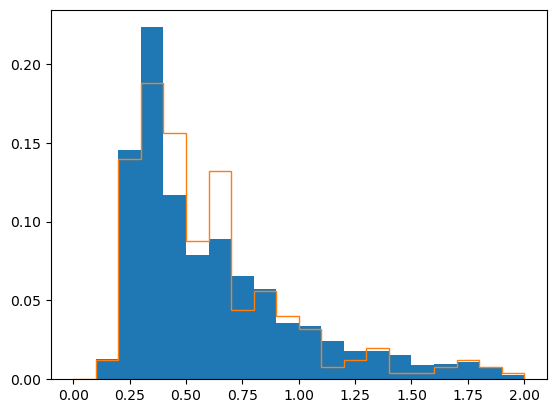

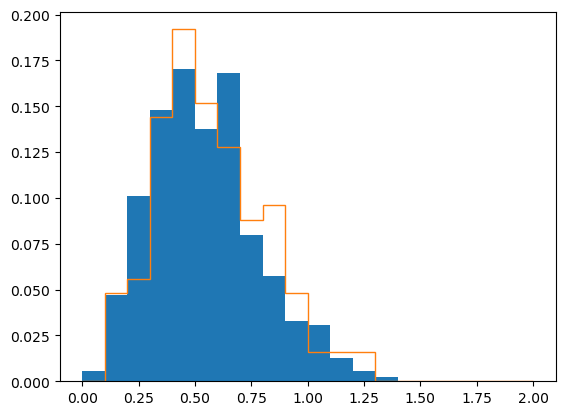

In [128]:
#All LSST unres systems:
all_lsst_unres_sys=np.loadtxt(mother_out_dir+'Unresolved_LSNeIa_Imag_cut22.6_theta_cut0.5.txt')

all_sysn,unique_id=np.unique(all_lsst_unres_sys[:,0],return_index=True)
NIss=all_lsst_unres_sys[unique_id,1]

all_double_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==2])
all_quad_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==4])



kappa_all,gamma_all,lens_z_all,s_z_all=all_lsst_unres_sys[:,2],all_lsst_unres_sys[:,3],all_lsst_unres_sys[:,5],all_lsst_unres_sys[:,4]
simon_good_kappa,simon_good_gamma,simon_good_lens_z,simon_good_s_z=all_good_downsampled_data[:,2],all_good_downsampled_data[:,3],all_good_downsampled_data[:,5],all_good_downsampled_data[:,4]
binsd=np.linspace(0,2,21)
plot_hist_percentage(gamma_all,bins=binsd,histtyep='bar')
plot_hist_percentage(simon_good_gamma,bins=binsd,histtyep='step')
plt.show()
plot_hist_percentage(lens_z_all,bins=binsd,histtyep='bar')
plot_hist_percentage(simon_good_lens_z,bins=binsd,histtyep='step')

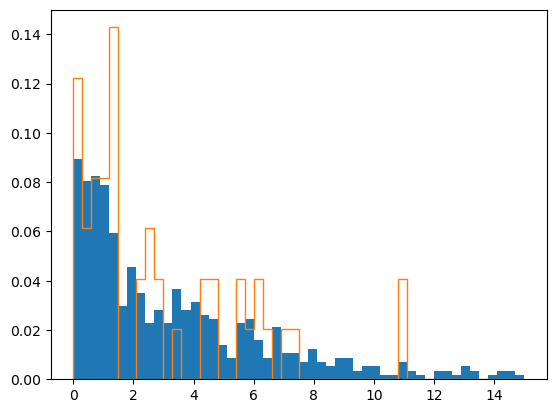

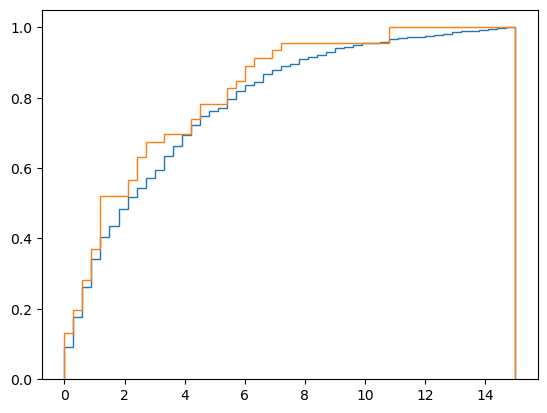

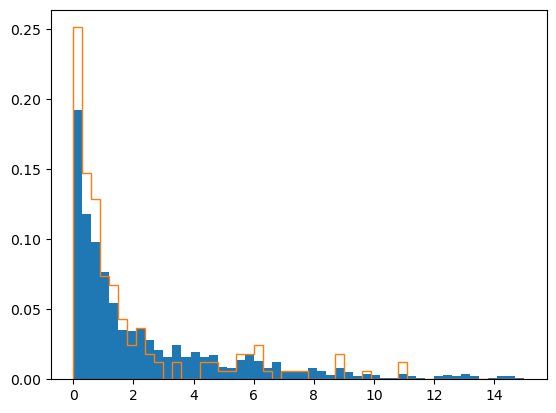

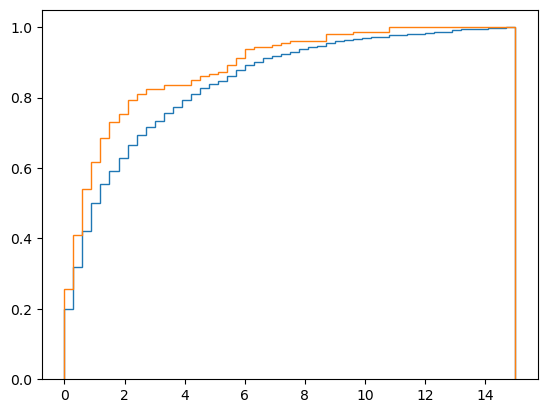

In [129]:
def get_mu_dt(sys_data):
    dts_sys=sys_data[:,6]; idx=np.argsort(dts_sys);dts_sys=dts_sys[idx];dts_sys=(dts_sys-dts_sys[0])
    mus_sys=np.abs(sys_data[:,7]);mus_sys=mus_sys[idx];mus_sys=mus_sys/mus_sys[0]
    return dts_sys[1:],mus_sys[1:]

def get_data_for_sysni(sysni,set_data):
    idx=np.where(all_lsst_unres_sys[:,0]==sysni)[0]
    if len(idx)>0:
        return set_data[idx,:]
    else:
        raise ValueError('system %d not found'%(sysni))
        
mus_list=[];dts_list=[]
mus_list_simon_good=[];dts_list_simon_good=[]

all_double_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==2])
all_quad_list=np.unique((all_lsst_unres_sys[:,0])[all_lsst_unres_sys[:,1]==4])

for ii,sysni in enumerate(all_double_list):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list.extend(mus_sysni);dts_list.extend(dts_sysni)

#simon good simulated list
for ii,sysni in enumerate(sysn_list_double):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list_simon_good.extend(mus_sysni);dts_list_simon_good.extend(dts_sysni)
    
binsd=np.linspace(0,15,51)
plot_hist_percentage(dts_list,bins=binsd,histtyep='bar')
plot_hist_percentage(dts_list_simon_good,bins=binsd,histtyep='step')
plt.show()

plt.hist(dts_list,cumulative=True,histtype='step',density=True,bins=binsd)
plt.hist(dts_list_simon_good,cumulative=True,histtype='step',density=True,bins=binsd)
plt.show()

for ii,sysni in enumerate(all_quad_list):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list.extend(mus_sysni);dts_list.extend(dts_sysni)
#simon good simulated list
for ii,sysni in enumerate(sysn_list_quad):
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    dts_sysni,mus_sysni=get_mu_dt(sysni_data);mus_list_simon_good.extend(mus_sysni);dts_list_simon_good.extend(dts_sysni)
    
binsd=np.linspace(0,15,51)
plot_hist_percentage(dts_list,bins=binsd,histtyep='bar')
plot_hist_percentage(dts_list_simon_good,bins=binsd,histtyep='step')
plt.show()
plt.hist(dts_list,cumulative=True,histtype='step',density=True,bins=binsd)
plt.hist(dts_list_simon_good,cumulative=True,histtype='step',density=True,bins=binsd)
plt.show()
    

In [130]:
sysn_list_quad

array([ 2178.,  3622.,  7256.,  7962.,  9512.,  9515., 11502., 12832.,
       13123., 14381., 14696., 17742., 18218., 18831., 21758., 25090.,
       25611., 25876., 26702., 27905., 31834., 33474., 35065., 35905.,
       35957., 40640., 42102., 42438., 42455., 43694., 47271., 47959.,
       49789., 51577., 53979., 54032., 55398., 55581.])

In [131]:
sysn_list_double

array([  798.,   833.,  1569.,  1831.,  2837.,  7106.,  7551.,  9277.,
       11930., 15361., 17368., 18305., 18525., 18957., 19880., 23144.,
       23395., 23645., 23785., 25091., 26268., 29499., 30146., 30862.,
       31682., 34294., 34453., 35397., 35707., 36119., 36596., 37655.,
       40082., 40697., 40810., 40915., 41059., 42523., 45600., 45949.,
       46230., 46337., 48095., 48584., 49072., 51307., 52144., 52739.,
       52850.])

In [132]:
def get_nearest_neighbour(data1,data2):
    k1,g1,sz1,lz1=data1
    k2,g2,sz2,lz2=data2
    kg_dist=np.sqrt((k2-k1)**2+(g2-g1)**2)
    ls_z_dist=np.sqrt((sz2-sz1)**2+(lz2-lz1)**2)
    return np.sum(kg_dist),np.sum(ls_z_dist)

def get_data_for_sysni(sysni,set_data):
    idx=np.where(set_data==sysni)[0]
    if len(idx)>0:
        return set_data[idx,:]
    else:
        #print('bad',sysni)
        raise ValueError('system %d not found'%(sysni[0]))

def find_best_matching_sys_id(dist_data):
    sys_id1=np.argmin(dist_data[:,0]**2+dist_data[:,1]**2)
    sys_id2=np.argmin(dist_data[:,0])
    sys_id3=np.argmin(dist_data[:,1])
    return sys_id1,sys_id2,sys_id3
def get_simon_good_sys_id(sysni):
#     if sysni in only_sysn_ni_data[:,0]:
#         return sysni
    sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
    ki,gi,s_zi,l_zi=sysni_data[:,2],sysni_data[:,3],sysni_data[:,4],sysni_data[:,5]
    datai=ki,gi,s_zi,l_zi
    NIi=len(ki); print(NIi)
    
    if NIi==2:
        serach_list=sysn_list_double
    elif NIi==4:
        serach_list=sysn_list_quad
    else:
        raise ValueError('NI=',NI)
    Nj=len(serach_list)
    dist_data=np.zeros((Nj,2))
    for jj,sysnj in enumerate(serach_list):
        sysnj_data= get_data_for_sysni(sysnj,all_good_downsampled_data)
        kj,gj,s_zj,l_zj=sysnj_data[:,2],sysnj_data[:,3],sysnj_data[:,4],sysnj_data[:,5]
        dataj=kj,gj,s_zj,l_zj
        kg_dist,ls_z_dist=get_nearest_neighbour(datai,dataj)
        #print(jj,kg_dist,ls_z_dist)
        dist_data[jj,:]=kg_dist,ls_z_dist
    #print('dist_data',dist_data)
    sys_id1,sys_id2,sys_id3=find_best_matching_sys_id(dist_data)
    print('best matching systems',serach_list[sys_id1],serach_list[sys_id2],serach_list[sys_id3])
    print('dustances-->',dist_data[sys_id1],dist_data[sys_id2],dist_data[sys_id3],'\n\n')
    print('(target) i sys->',ki,gi,s_zi,l_zi)
    sysnj_found_data= get_data_for_sysni(serach_list[sys_id1],all_good_downsampled_data)
    kj,gj,s_zj,l_zj=sysnj_found_data[:,2],sysnj_found_data[:,3],sysnj_found_data[:,4],sysnj_found_data[:,5]
    print('(found) i sys->',kj,gj,s_zj,l_zj)
    print('\n\n\n')
    #print(serach_list)
    return serach_list[sys_id1]
    

#get_simon_good_sys_id(798)
Nall=len(all_sysn)#=711
assigned_sys=[]
assigned_sys_arr=np.zeros((Nall,2))
    
for ii,sysni in enumerate(all_sysn):
    
    print(sysni);sysnj=get_simon_good_sys_id(sysni); 
    assigned_sys.append(sysnj)
    assigned_sys_arr[ii]=sysni,sysnj
#     sysnj_data= get_data_for_sysni(sysnj,all_good_downsampled_data)
#     sysnj_dts,sysnj_mus=np.zeros(3),np.zeros(3)
#     sysnj_dts1,sysnj_mus1=get_mu_dt(sysnj_data)
#     if len(sysnj_dts1)==1: 
#         sysnj_dts[:1],sysnj_mus[:1]=sysnj_dts1,sysnj_mus1
#     elif len(sysnj_dts1)==3:
#         sysnj_dts,sysnj_mus=sysnj_dts1,sysnj_mus1
#     else:
#         raise ValueError('Problem 171')
#     assigned_sys_arr[ii,2:]=np.hstack((sysnj_dts,sysnj_mus))

81.0
2
best matching systems 833.0 11930.0 45949.0
dustances--> [0.43111326 0.43638973] [0.11752246 1.076     ] [1.06803098 0.22289908] 


(target) i sys-> [0.3167289 0.7586573] [0.30977698 0.764865  ] [0.52 0.52] [0.134 0.134]
(found) i sys-> [0.2810854 1.022791 ] [0.26494774 1.02942205] [0.6 0.6] [0.337 0.337]




152.0
2
best matching systems 11930.0 42523.0 34294.0
dustances--> [0.24640094 0.23259407] [0.0739498  1.09588503] [2.38387201 0.22912006] 


(target) i sys-> [0.3205844 0.8589858] [0.32033491 0.86381566] [1.09 1.09] [0.167 0.167]
(found) i sys-> [0.3684357 0.7452746] [0.38070389 0.73829636] [1.04 1.04] [0.272 0.272]




162.0
2
best matching systems 34453.0 40915.0 51307.0
dustances--> [0.24619012 0.38832976] [0.23955924 0.62831839] [0.71986515 0.19697716] 


(target) i sys-> [0.4116028 1.405578 ] [0.40681833 1.39599171] [0.99 0.99] [0.17 0.17]
(found) i sys-> [0.2933438 1.336444 ] [0.29784215 1.34589531] [0.8 0.8] [0.21 0.21]




238.0
2
best matching systems 23144.0 4633

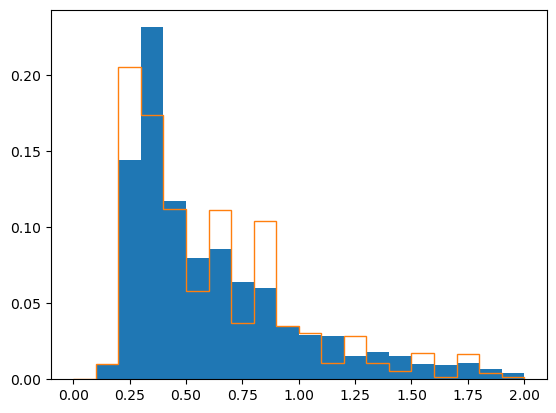

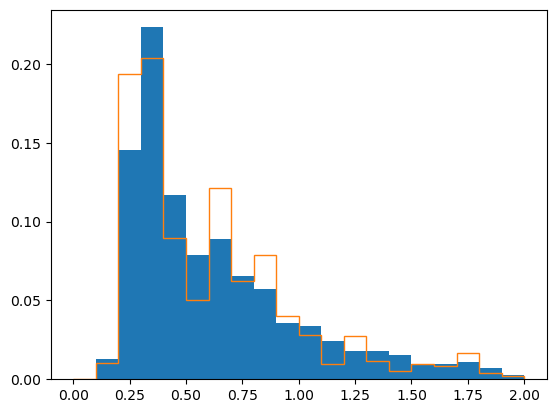

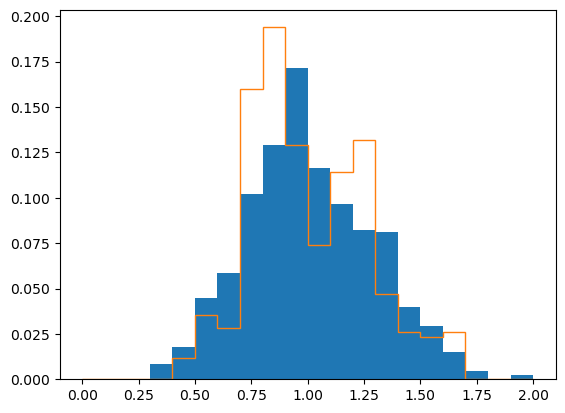

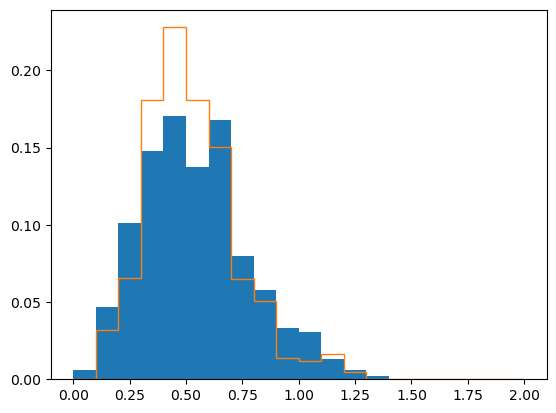

In [133]:
xx,yy=np.unique(assigned_sys, return_counts=True)
np.sum(yy)
kappa_test=[];gamma_test=[];s_z_test=[];lens_z_test=[]
for sysnj in assigned_sys:
    sysnj_data= get_data_for_sysni(sysnj,all_good_downsampled_data)
    kj,gj,s_zj,l_zj=sysnj_data[:,2],sysnj_data[:,3],sysnj_data[:,4],sysnj_data[:,5]
    kappa_test.extend(kj);gamma_test.extend(gj)
    s_z_test.extend(s_zj);lens_z_test.extend(l_zj)
    
binsd=np.linspace(0,2,21) 
plot_hist_percentage(kappa_all,bins=binsd,histtyep='bar')
plot_hist_percentage(kappa_test,bins=binsd,histtyep='step')
plt.show()

plot_hist_percentage(gamma_all,bins=binsd,histtyep='bar')
plot_hist_percentage(gamma_test,bins=binsd,histtyep='step')
plt.show()

plot_hist_percentage(s_z_all,bins=binsd,histtyep='bar')
plot_hist_percentage(s_z_test,bins=binsd,histtyep='step')
plt.show()

plot_hist_percentage(lens_z_all,bins=binsd,histtyep='bar')
plot_hist_percentage(lens_z_test,bins=binsd,histtyep='step')
plt.show()

711


(array([  3.,   7.,   4.,  21.,  22.,  46.,  82.,  98., 203., 225.]),
 array([19.06055788, 19.41430398, 19.76805008, 20.12179618, 20.47554227,
        20.82928837, 21.18303447, 21.53678057, 21.89052667, 22.24427277,
        22.59801886]),
 <BarContainer object of 10 artists>)

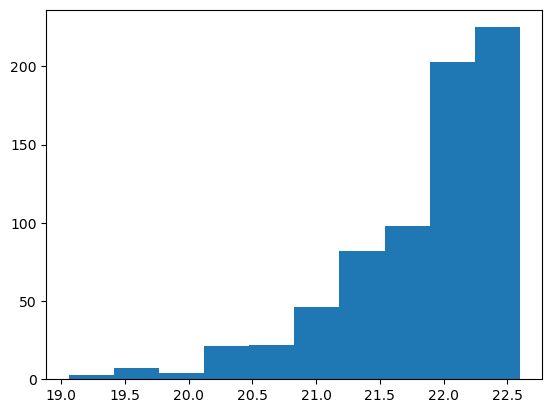

In [134]:
all_models=np.array(['me', 'n1', 'su', 'ww'])
def get_indi(data_mat,sysn):
    return np.where(data_mat[:,0]==sysn)[0]
def construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,modelname,s_val):
    return 'SN_%s_k%.6f_g%.6f_s%.3f_redshift_source%.3f_lens%.3f_Nsim_100'%(modelname,kappa_i,gamma_i,s_val,s_z_i,lens_z_i)
def get_total_flux_mag(sysnlist):
    total_flux=[]
    total_mag=[]
    for sysn in sysnlist:
        ids=get_indi(all_lsst_unres_sys,sysn)
        mu_image, source_mag=all_lsst_unres_sys[ids,7:9].T
        tot_flux=np.sum(np.abs(mu_image)*st.get_flux(source_mag))
        tot_mag=st.get_mag(tot_flux)
        total_flux.append(tot_flux);total_mag.append(tot_mag)
    return np.array(total_flux), np.array(total_mag)
total_flux,total_mag=get_total_flux_mag(all_sysn)
print(len(total_mag))
plt.hist(total_mag)

In [135]:
import five_sigma_depth_func_of_time
# import pickle
# import load_light_curves

def f_observational_uncertainty(magnitude,five_sigma_depth,filter_,sigma_sys=0.005):
    mag_diff = magnitude-five_sigma_depth
    #mag_diff[mag_diff >= 3] = np.nan #sets everything which is to faint to nan
    x=10**(0.4 * mag_diff)
    gamma = {"u": 0.037, "g": 0.038, "r": 0.039, "i": 0.039, "z": 0.040, "y":0.040, "J":0.040, "H":0.040, "K":0.040}
    sigma_rand_squared = (0.04 - gamma[filter_]) * x + gamma[filter_] * x**2
    sigma_total = np.sqrt(sigma_sys**2 + sigma_rand_squared) #unit magnitude
    #print(magnitude, sigma_total)
    return sigma_total


def get_five_sigma_depth(time,filter_,moon_phase_yes_no=False):
    # get the five sigma depth
    depth_filter_ = 24.7
    

    if moon_phase_yes_no:
        # start_in_moon_phase, 0 assumes first quarter, 29.5/4 assumes  full moon, 29.5/2 assumes third quarter, 29.5*3/4 assumes new moon, 29.5 is then again firt quarter    
        start_in_moon_phase = 29.5/4
        fsd = five_sigma_depth_func_of_time.five_sigma_depth(filter_=filter_)
        
        five_sigma_depth = fsd.f_five_sigma_depth_as_function_of_time_ESO(time_to_get_five_sigma_depth = time,
                                                                          reference_depth=depth_filter_,
                                                                          start_in_moon_phase=start_in_moon_phase)
    else:
        five_sigma_depth = np.full(time.shape,depth_filter_)
        
    return five_sigma_depth

def get_artificial_mag_obs(mag,mag_sig,five_sigma_depth):
    mag_obs=np.random.normal(mag,mag_sig)
    #return mag_obs
    ids=np.where((mag_obs<five_sigma_depth) &(mag-five_sigma_depth>0.0))[0]
    if len(ids):
        mag_obs[ids]=np.random.uniform(five_sigma_depth[ids],mag[ids])
    return mag_obs
    

In [136]:
icheck=11
sysn_check=sysn_list_quad[icheck]
isysn=np.where(only_sysn_ni_data[:,0]==sysn_check)[0][0]
target_mag=total_mag[isysn]
print('sysn=',sysn_check,'target mag=',target_mag)


def get_Cs(peak_mags,mus,target_mag):
    NI=len(peak_mags)
    if NI!=len(mus)+1:
        raise ValueError("Problem, lengths of peak mag and mus are not matching")
    Cs=np.zeros(NI)
    peak_fluxes=st.get_flux(peak_mags)
    #print('target_flux=',st.get_flux(target_mag))
    Cs[0]=st.get_flux(target_mag)/(peak_fluxes[0]*(1.0+np.sum(mus)))
    for ii in range(1,NI):
        Cs[ii]=mus[ii-1]*Cs[0]*peak_fluxes[0]/peak_fluxes[ii]
    return Cs

def get_Cs2(peak_mags,mus1,target_mag):
    print("from ML-->", get_flux(peak_mags)/get_flux(peak_mags)[0])
    return get_flux(target_mag)/np.sum(get_flux(peak_mags))


ids=get_indi(all_good_downsampled_data,sysn_check)
band="i"
NI=len(ids)
if NI:
    for imod,model_i in enumerate(all_models):
        mus1=10*np.random.rand(NI-1)
        peak_mags=np.zeros(len(ids))
        for ni,ii in enumerate(ids):
            kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
            s_val=all_good_downsampled_data[ii,-1]

            fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
            image_path=mother_out_dir+'sysn_%d/'%(sysn_check)+fname
            if not os.path.exists(image_path):
                print("Problem!!")
            else:
                macro_key='macro_light_curve_%s'%(band)
                macro_mag=np.loadtxt(image_path+'/'+macro_key)
                imicro=np.random.randint(100);micro_key='micro_light_curve_%s%s'%(imicro,band)
                micro_mag=np.loadtxt(image_path+'/'+micro_key)
                peak_mags[ni]=np.min(micro_mag)
        Cs=get_Cs(peak_mags,mus1,target_mag)
        image_fluxes=Cs*st.get_flux(peak_mags)
        summed_up_mag=st.get_mag(np.sum(image_fluxes))
        print('final=',summed_up_mag,mus1,image_fluxes/image_fluxes[0])

sysn= 17742.0 target mag= 22.005425242156697
final= 22.0054252421567 [0.83859101 3.1390516  3.51742051] [1.         0.83859101 3.1390516  3.51742051]
final= 22.0054252421567 [8.85350463 1.27968628 4.54951445] [1.         8.85350463 1.27968628 4.54951445]
final= 22.0054252421567 [5.27365105 3.82918637 7.41010668] [1.         5.27365105 3.82918637 7.41010668]
final= 22.0054252421567 [1.87772935 2.3394343  6.60696259] [1.         1.87772935 2.3394343  6.60696259]


In [137]:
def get_Om10_system(NI):
    if NI==1:
        sysn=np.random.choice(only_sysn_ni_data[:,0]) 
    elif NI==2:
        sysn=np.random.choice(sysn_list_double)
    elif NI==4:
        sysn=np.random.choice(sysn_list_quad)
    else:
        print("NI=",NI)
        raise ValueError("Problem NI should be 1 or 2 or 4")
    return sysn

In [138]:
def get_intersection(list1):
    list_union = list(set().union(*list1))
    list_intersection =list(set.intersection(*map(set, list1)))
    return sorted(list_union), sorted(list_intersection)
# list1 = [[1,2,3], [1,2,4]]
# get_intersection(list1) 
def arrange_sys_obs_mjd(Good_sys_band,Good_sys_obs_mjd_band,bands_used,Good_sys_obs_fiveSigmaDepth_band):
    Good_sys_obs_mjd_in_all_bands=[[] for _ in bands_used]
    Good_sys_obs_fiveSigmaDepth_in_all_bands=[[] for _ in bands_used]
    for iband,band in enumerate(bands_used):
        idx=np.where(np.isin(Good_sys_band[iband],good_sn_in_all_bands))[0]
        #print(min_max(good_sn_in_all_bands-np.array(Good_sys_band[iband])[idx]))
        Good_sys_obs_mjd_in_all_bands[iband]= [(Good_sys_obs_mjd_band[iband])[idxx] for idxx in idx]
        Good_sys_obs_fiveSigmaDepth_in_all_bands[iband]=[(Good_sys_obs_fiveSigmaDepth_band[iband])[idxx] for idxx in idx]
    return Good_sys_obs_mjd_in_all_bands,Good_sys_obs_fiveSigmaDepth_in_all_bands


Nsss=711*10000 # total number of dummy SN simulated to get their cadence
bands_used=['r','i','z','y']
file_name = "Good_cadence_systems_fiveSigmaDepth_riyz.pkl"
with open(file_name, 'rb') as file:
    loaded_data = pickle.load(file)

Good_sys_band=loaded_data['Good_sys_band']
Good_sys_obs_mjd_band=loaded_data['Good_sys_obs_mjd_band']
Good_sys_obs_fiveSigmaDepth_band=loaded_data['Good_sys_obs_fiveSigmaDepth_band']

all_good_sn, good_sn_in_all_bands=get_intersection(Good_sys_band)
print('#of all good sys (union)=',len(all_good_sn),'# of good sys observed in all the bands=',len(good_sn_in_all_bands))
print('in percentage: ',100*len(all_good_sn)/Nsss,100*len(good_sn_in_all_bands)/Nsss)

Good_sys_obs_mjd_in_all_bands,Good_sys_obs_fiveSigmaDepth_in_all_bands=arrange_sys_obs_mjd(Good_sys_band,Good_sys_obs_mjd_band,bands_used,Good_sys_obs_fiveSigmaDepth_band)
print(len(Good_sys_obs_mjd_in_all_bands[0]))
Ngood_cadence=len(good_sn_in_all_bands);print(Ngood_cadence)

#of all good sys (union)= 1334273 # of good sys observed in all the bands= 442608
in percentage:  18.766146272855135 6.225147679324895
442608
442608


In [139]:
cadence_id=np.random.choice(Ngood_cadence)
t_arrs=[(Good_sys_obs_mjd_in_all_bands[ii])[cadence_id] for ii in range(4)]
print(t_arrs)

[array([ 10.58989856,  12.54303338,  12.62994699,  16.41823422,
        16.61383015,  18.5260763 ,  19.60212999,  24.3642766 ,
        24.56835408,  38.61779032,  38.62093939,  39.54288775,
        45.52564297,  56.54043779,  57.48099956,  67.47906802,
        71.4780255 ,  76.39399776,  76.47764093,  84.42726552,
       106.37539118, 107.37718706, 108.3585368 , 112.37420167,
       112.37510074, 113.36948735, 133.30279409, 134.30855535]), array([ 10.61507734,  19.6363868 ,  22.63362828,  28.36535191,
        28.55346323,  38.64169113,  51.52410692,  51.54673693,
        52.49491468,  54.5019329 ,  54.50240012,  65.50102554,
        67.50283056,  71.50223373,  84.45117961,  92.46840444,
       108.38275136, 110.40888369, 133.32702052, 134.33299126]), array([  1.65383685,   9.609236  ,  11.65264344,  19.64823959,
        22.6448155 ,  28.34164276,  37.55991582,  51.54851934,
        52.51908934,  58.40760367,  59.40993468,  59.41043786,
        59.58372656,  59.58417546,  61.49605293,  

In [140]:
def f_load_microlensed_lightcurves(sysn,band,micro_configs,sn_model,NI,unlensed_im_choice=0):
    ids=get_indi(all_good_downsampled_data,sysn); NI1=len(ids)
    if NI==1:
        #print("satadru: entered here unlensed", unlensed_im_choice,band)
        #ids=np.array([ids[np.random.choice(NI1)]])
        ii=ids[unlensed_im_choice]
        macro_mags=[]
        mjds=[]
        kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
        s_val=all_good_downsampled_data[ii,-1]

        fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
        image_path=mother_out_dir+'sysn_%d/'%(sysn)+fname
        
        time_key='time_bin_center'
        time_filter=np.loadtxt(image_path+'/'+time_key)
        mjds.append(time_filter)
        macro_key='macro_light_curve_%s'%(band)
        macro_mag=np.loadtxt(image_path+'/'+macro_key)
        macro_mags.append(macro_mag)
        return mjds, macro_mags
        
    #macro_mags=[]
    micro_mags=[]
    mjds=[]
    for ni in range(NI):
        ii=ids[ni]
        kappa_i,gamma_i,s_z_i,lens_z_i=all_good_downsampled_data[ii,2:6]
        s_val=all_good_downsampled_data[ii,-1]

        fname=construct_fname(kappa_i,gamma_i,s_z_i,lens_z_i,model_i,s_val)
        image_path=mother_out_dir+'sysn_%d/'%(sysn)+fname
        
        time_key='time_bin_center'
        time_filter=np.loadtxt(image_path+'/'+time_key)
        mjds.append(time_filter)

#         macro_key='macro_light_curve_%s'%(band)
#         macro_mag=np.loadtxt(image_path+'/'+macro_key)
        #imicro=np.random.randint(100);
        micro_key='micro_light_curve_%s%s'%(micro_configs[ni],band)
        micro_mag=np.loadtxt(image_path+'/'+micro_key)
        micro_mags.append(micro_mag)
        

    return mjds, micro_mags
        
#f_load_microlensed_lightcurves(798,'i',[12,77],'ww')    

In [141]:
clrs=['r','orange','brown','magenta']

def build_unresolved(params):
    t_arrs,fivesigDepth_arrs,system_number,NI,micro_configs,filters,supernova_model,dts,mus,target_mag=params
    #filter_data=get_lcs(system_number,NI,micro_configs,filters,supernova_model)
    #filter_data=aa
    
    #print("mus test",mus,dts,"NI=",NI)
    
    isysn=np.where(only_sysn_ni_data[:,0]==system_number)[0][0]
    #target_mag=total_mag[isysn]
    available_NI=only_sysn_ni_data[:,1][isysn].astype(int)
    
    Flist=[]#np.zeros(Nfilters,dtype=object)
    Flist_true=[]
    Mag_list=[]
    Mag_true=[]
    
    mjd_list_band_ni=[[] for i in range(Nfilters)]
    micro_mag_list_band_ni=[[] for i in range(Nfilters)]
    
    random_ni_for_unlensed=np.random.choice(available_NI)
    
    #NoiseP.extend(noise_level)
    for ifilter,filter_ in enumerate(filters):
        
        
        mjds, micro_mags=f_load_microlensed_lightcurves(system_number,filter_,micro_configs,supernova_model,NI,random_ni_for_unlensed)
        mjd_list_band_ni[ifilter].extend(mjds)
        micro_mag_list_band_ni[ifilter].extend(micro_mags)
        
        if len(mjds)!=NI and NI!=1:
            raise ValueError("Problem: NI does not match !!!")
            sys.exit()
            
        #this part is to match the peak combined mag (I-band) to the input from OM10. 
        #Otherwise, the simulated system can be too bright or too faint with respect to LSST I-band limiting mag.
        #Too faint systems won't be seen by LSST, so they should be avoided.
        if filter_=='i':
            peak_mags=np.array([np.min(micro_mag) for micro_mag in micro_mags])
            C0=get_flux(target_mag)/np.sum(get_flux(peak_mags))
            
        
    #return  mjd_list_band_ni,micro_mag_list_band_ni
    for ifilter,filter_ in enumerate(filters):
        mjds=mjd_list_band_ni[ifilter]
        micro_mags=micro_mag_list_band_ni[ifilter]
        t_filter=t_arrs[ifilter]
        five_sigma_depth_filter=fivesigDepth_arrs[ifilter]
        t_maxes[ifilter].extend([t_filter.max()]);
        
        flux_filter=np.zeros(len(t_filter))
        for ni in range(NI):
            flux_micro=get_flux(micro_mags[ni])
            flux_interp=get_interp(mjds[ni],flux_micro)
            flux_image=C0*flux_interp(t_filter-dts[ni])
#             plt.plot(t_filter,flux_image,alpha=0.4,label=r"band=%s::image=%d"%(filter_,ni+1))
            flux_filter+=flux_image
        
#         plt.plot(t_filter,flux_filter,lw=2.0,c="k",ls="--")
#         plt.legend()
#         plt.show()
            
        
        Mag=get_mag(flux_filter)
        five_sigma_depth=get_five_sigma_depth(t_filter,filter_,moon_phase_yes_no=True)
        sigma_total = f_observational_uncertainty(Mag,five_sigma_depth=five_sigma_depth,filter_=filter_,sigma_sys=0.005)
        sigma_total=np.clip(sigma_total,0,1.0)
        Mag_obs=np.random.normal(Mag,sigma_total)
        #Mag_obs=get_artificial_mag_obs(Mag,sigma_total,five_sigma_depth)
        
        
        Fobs=get_flux(Mag_obs)
        Ferr=get_flu_err(Mag_obs,sigma_total)


        


        sigma_total_2 = f_observational_uncertainty(Mag,five_sigma_depth=five_sigma_depth_filter,filter_=filter_,sigma_sys=0.005)
        #sigma_total_2=np.clip(sigma_total_2,0,2.0)
        #Mag_obs_2=np.random.normal(Mag,sigma_total_2)
        Mag_obs_2=get_artificial_mag_obs(Mag,sigma_total_2,five_sigma_depth_filter)
        Fobs_2=get_flux(Mag_obs_2)
        Ferr_2=get_flu_err(Mag_obs_2,sigma_total_2)
        
#         Fsig3=get_flux(five_sigma_depth_filter)/5
#         Fobs_3=np.random.normal(flux_filter,Fsig3)
        
#         plt.errorbar(t_filter,Mag_obs,yerr=sigma_total,fmt='c*',label=r"observed")
#         plt.errorbar(t_filter-1.0,Mag_obs_2,yerr=sigma_total_2,fmt='k*',label=r"observed2")
#         plt.plot(t_filter,Mag,c=clrs[ifilter],lw=2.0,label=r"true")
#         plt.legend()
#         plt.title(r"sysn=%d :: filter=%s"%(system_number,filter_))
#         plt.show()
        
#         plt.plot(t_filter,flux_filter,c=clrs[ifilter],lw=2.0,label=r"true")
#         plt.errorbar(t_filter,Fobs,yerr=Ferr,fmt='c*',label=r"observed")
#         plt.errorbar(t_filter-1.0,Fobs_2,yerr=Ferr_2,fmt='k*',label=r"observed2")
#         plt.errorbar(t_filter+1.0,Fobs_3,yerr=Fsig3,fmt='b*',label=r"observed3")

#         plt.legend()
#         plt.title(r"sysn=%d :: filter=%s"%(system_number,filter_))
#         plt.show()
        
#         print(five_sigma_depth,'\n',five_sigma_depth_filter)
        Mag_list.extend([t_filter,Mag_obs_2,sigma_total_2])
        Mag_true.extend([Mag])
        Flist.extend([t_filter,Fobs_2,Ferr_2])
        Flist_true.extend([flux_filter])
        
        
    
    return Flist,Flist_true,Mag_list,Mag_true
        
        
        
        
 

In [142]:
runid=0
setid=1



Setnames=['Train','Test']
Setname=Setnames[setid]

master_imagefileN='Imgae_details'
master_LCfileN='lc_file'

templates=["ww","me", "n1", "su"]

random_seeds=[1101,154587]# for tarining and testing
#System_numbers=[70000,30000] # for tarining and testing
#np.random.seed(random_seeds[setid])#for training
np.random.seed(97985)
filters=["r",'i',"z","y"]
Nfilters=calculate_length(filters)

over_sam_fac=100

sample_list=all_sysn; 
Nsam_sys=len(sample_list)

Nsys=Nsam_sys*over_sam_fac
Systems=(50000+np.arange(Nsys)).astype(int)
NIs=np.full(Nsys,-1)

dts,mus=np.zeros((Nsys,4)),np.zeros((Nsys,4));mus[:,0]=1.0


template_max=2
template_choice=np.random.choice(template_max,size=Nsys)
Om10_systems=np.zeros(Nsys).astype(int)
LC_simon_sys=np.zeros(Nsys).astype(int)
micro_configs_save=np.full((Nsys,4),-1)


out_dir='./out_dir/without_clip_sata%d_setLSST_templates%d/'%(runid,template_max)
st.create_dir(out_dir)

fout_images=out_dir+'%s_%s.txt'%(Setname,master_imagefileN)
lc_filename=out_dir+'%s_%s.h5'%(Setname,master_LCfileN)



Output path already exists


In [143]:
time_start=time.time()
t_maxes=[[],[],[],[]]

isys=0
with h5py.File(lc_filename,'w') as h5f:
    for imaster,sysni in enumerate(sample_list):
        target_simon_sys=assigned_sys_arr[imaster,1]
        NI=int(NIss[imaster])
        sysni_data= get_data_for_sysni(sysni,all_lsst_unres_sys)
        dts_sysni,mus_sysni=get_mu_dt(sysni_data);
        mus_sysni=(3.0-1./3)*np.random.rand(NI-1)+1/3.0#np.clip(3.0*mus_sysni,0.33,3.0)

        cadence_id=np.random.choice(Ngood_cadence)
        t_arrs=[(Good_sys_obs_mjd_in_all_bands[ii])[cadence_id] for ii in range(4)]
        fivesigDepth_arrs=[(Good_sys_obs_fiveSigmaDepth_in_all_bands[ii])[cadence_id] for ii in range(4)]


        target_mag=total_mag[imaster]
        for jj in range(over_sam_fac):
            dts[isys][1:NI]=dts_sysni
            mus[isys][1:NI]=mus_sysni
            Om10_systems[isys]=sysni
            LC_simon_sys[isys]=target_simon_sys
            supernova_model=templates[template_choice[isys]]
            micro_configs=np.random.randint(0,99,NI); 
            micro_configs_save[isys][:NI]=micro_configs
            #print('micro_configs=',micro_configs)
            dts_im=dts[isys]
            params=t_arrs,fivesigDepth_arrs,target_simon_sys,NI,micro_configs,filters,supernova_model,dts_im,mus[isys],target_mag


            Flist,Flist_true,Mag_list,Mag_true=build_unresolved(params)
            dump_to_h5([Systems[isys],Mag_list],labs)
            NIs[isys]=NI
            isys+=1

        #print(ii,sysni,target_simon_sys,NI)



print("Elapsed time=", time.time()-time_start)

NoiseP=np.full(Nsys,-1)#LSST like noise, not fixed in all time, so this is not important
t_maxes1=np.array(t_maxes).T
f=open(fout_images,'w')
f.write('#random seed used=%d \n'%(random_seeds[setid]))
f.write("#SysNo\tOm10_system\t NI\t mu1\t mu2\t mu3\t dt1\t dt2 \t dt3 \t micro conigs: 1, 2, 3, 4  \t tr_max \t ti_max \t tz_max \t ty_max \t NoiseP \t template\tLC_sysn\n")
   
np.savetxt(f,np.c_[Systems,Om10_systems,NIs,mus[:,1:],dts[:,1:],micro_configs_save,t_maxes1,NoiseP,template_choice,LC_simon_sys],fmt='%i\t'*3+'%s\t'*6+'%i\t'*4+'%.3f\t'*4+'%.2f'+'\t%d'+'\t%d')
f.close()
#print("Elapsed time=", time.time()-time_start)

Elapsed time= 268.0418350696564
